# 0. Ley de gravitación universal

Este experimento tiene como objetivo redescrubrir la ley de gravitación universal utilizando una KAN. Esta ley nos da una fórmula para calcular la fuerza ejercida entre dos cuerpos de masas $m_1$ y $m_2$ separados por una distancia $d$. La fórmula es la siguiente
$$
F = G \frac{m_1 m_2}{d^2}, \quad G=6.6743 \cdot 10^{-11} \frac{\text{Nm}^2}{\text{kg}^2}.
$$

Para entrenar el modelo vamos a utilizar datos sintéticos, es decir, no vamos a utilizar mediciones reales, sino que simularemos los datos. Los datos simulados representan estrellas cercanas al Sol, concretamente aquellas que se encuentran a $5$ parsecs del Sol. Además, hemos fijado algunas restricciones: consideramos solo estrellas de $0.5$ a $5$ masas solares, comparamos estrellas que estén a más de $1$ parsec de distancia y descartamos aquellas interacciones entre dos estrellas que tienen una fuerza menor que $10^{16}$ N.

Una masa solar ($M_\odot$) es una unidad de masa que equivale a la masa del Sol ($1.989 \cdot 10^{30} \text{ kg}$). Por su parte, el parsec es una unidad de distancia que equivale a $3.086 \cdot 10^{16} \text{ m}$. Dado que vamos a trabajar con parsecs y masas solares, expresaremos la constante $G$ también en estas unidades
$$
G' = 6.6743 \cdot 10^{-11} \frac{\text{Nm}^2}{\text{kg}^2} \cdot \frac{(1.989 \cdot 10^{30})^2 \text{ kg}^2}{1 \text{ M}^2_\odot} \cdot \frac{1 \text{ parsec}^2}{(3.086 \cdot 10^{16})^2 \text{ m}^2} = 2.773 \cdot 10^{17} \frac{\text{N} \text{ parsec}^2}{\text{M}_\odot^2}.
$$

Dado que no sabemos qué arquitectura de KAN utilizar, comenzamos con una (3,5,1).

In [120]:
# Iniciamos la KAN
from kan import *
import scipy.constants as const

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = KAN(width=[3,5,1], grid=3, k=3, seed=2025, device=device);

checkpoint directory created: ./model
saving model version 0.0


A continuación, tenemos el código que genera los datos asociados a las variables $m_1$, $m_2$ y $d$ de la fórmula de la gravitación universal. Recordemos que queremos simular las estrellas a menos de $5$ parsecs de distancia del Sol con masas entre $0.5$ y $5 \ M_\odot$. Podríamos generar estos datos utilizando una distribución uniforme, sin embargo, no sería demasiado realista.

Llamemos $R$ a la variable aleatoria que describe la distancia entre el Sol y una estrella aleatoria con radio interior $r_{min}=1.295$ y radio exterior $r_{max}=5$. El radio interior viene dado por la distancia a la estrella más cercana al Sol (Próxima Centauri) y el radio exterior por la restricción que hemos fijado. Llamaremos $\mathcal{C}$ a la corona esférica que representa ese espacio (corona esférica con radio interior $r_{min}$ y radio exterior $r_{max}$). Para poder determinar cómo se distribuye $R$ es razonable asumir que en un entorno local como en el que estamos trabajando las estrellas se distribuyen con densidad constante. Por lo tanto, las estrellas se distribuyen de manera constante en volumen y la probabilidad de que una estrella se encuentre a una cierta distancia $r$ no es uniforme en $r$, sino que es proporcional a $r^2$ (el área de una esfera de radio $r$ es $4\pi r^2$). Entonces, la función de densidad de $R$ es
$$
f_R(r) = \frac{3r^2}{r_{max}^3 - r_{min}^3}, \quad r \in [r_{min}, r_{max}],
$$
donde $\frac{3}{r_{max}^3 - r_{min}^3}$ es la constante que hay que aplicar para que $f_R$ integre $1$. Para obtener un método que nos permita obtener muestras de $R$ necesitamos calcular la función de distribución acumulada
$$
F_R(r) = \int_{r_{min}}^r f_R(t) dt = \frac{r^3 - r_{min}^3}{r_{max}^3 - r_{min}^3}, \quad r \in [r_{min}, r_{max}].
$$

Entonces, sea $U \sim \text{Unif}(0,1)$ y escribimos $R$ como
$$
R = F_R^{-1}(U) = (U(r_{max}^3 - r_{min}^3) + r_{min}^3)^{1/3},
$$
utilizando el método de la transformada inversa. Esto nos da un procedimiento para obtener muestras de $R$, sin embargo, no estamos interesados directamente en la distancia que hay de las estrellas al Sol, sino en la distancia que hay entre dos de estrellas situadas en la corona esférica $\mathcal{C}$. Veamos cómo generar muestras de esta distribución.

Comenzamos generando una muestra de $n$ observaciones de la variable aleatoria $R$. A continuación, generamos $n$ observaciones de las variables aleatorias independientes $\Theta$ y $\Phi$, que describen ángulos en coordenadas esféricas. La generación de estas observaciones viene dada por
$$
\Theta = \arccos(1-2U_\Theta), \quad \Phi = 2\pi U_\Phi, \quad U_\Theta, U_\Phi \sim \text{Unif}(0,1),
$$
ya que hemos asumido densidad constante (con un mismo radio la probabilidad de encontrar una estrella es uniforme). Definimos el vector aleatorio $X$ como $X =(X_1, X_2, X_3)$ con
\begin{align*}
X_1 &= R \sin \Theta \cos \Phi, \\
X_2 &= R \sin \Theta \sin \Phi, \\
X_3 &= R \cos \Theta.
\end{align*}
Este vector aleatorio $X$ representa una posición aleatoria de una estrella en coordenadas cartesianas en la corona esférica $\mathcal{C}$. Entonces, para generar una muestra de $n$ observaciones de $X$ basta con utilizar las muestras de $n$ observaciones de las variables aleatorias $R$, $\Theta$ y $\Phi$. Llamamos $Y_1, Y_2 \sim X$ a dos vectores aleatorios independientes e idénticamente distribuidos. Finalmente, definimos la variable aleatoria $D$ que representa la distancia entre dos estrellas elegidas aleatoriamente en la corona esférica $\mathcal{C}$ como
$$
D = \|Y_1 - Y_2 \|,
$$
donde $\|.\|$ denota la norma euclídea en $\mathbb{R}^3$. Entonces para generar una muestra de $n$ observacioes de $D$, basta con utilizar muestras de $n$ observaciones de los vectores aleatorios $Y_1, Y_2$.

Veamos ahora cómo generar las masas de las estrellas en el experimento. Sea $M$ la variable aleatoria que describe la masa de una estrella seleccionada al azar. Estamos interesados solo en aquellas estrellas que tienen una masa entre $m_{min}=0.5$ y $m_{max}=5$ $\text{M}_\odot$. La forma en la que se distribuyen las masas estelares no es uniforme. Para describir la distribución de las masas de las estrellas seguiremos la función de masa inicial, en concreto la formulación de \citet{kroupa2001variation}. De esta manera, para masas mayores que $0.5 M_\odot$ tenemos que la función de densidad de $M$ cumple que
$$
f_M(m) \propto m^{-\alpha} \text{ con } \alpha = 2.3,
$$
es decir, estrellas con una menor masa son más frecuentes que las que tienen una mayor masa. Ajustando la función $f_M$ para que su integral sea $1$ en el intervalo que hemos considerado, tenemos que
$$
f_M(m) = \frac{(1-\alpha)m^{-\alpha}}{m_{max}^{1-\alpha}-m_{min}^{1-\alpha}}, \quad m \in [m_{min}, m_{max}].
$$

Aplicamos nuevamente el método de la transformada inversa. Para ello, calculamos la función de distribución acumulada $F_M$
$$
F_M(m) = \int_{m_{min}}^m f_M(t) dt = \frac{m^{1-\alpha} - m_{min}^{1-\alpha}}{m_{max}^{1-\alpha}- m_{min}^{1-\alpha}}
$$
y utilizando una uniforme $U \sim \text{Unif}(0,1)$ tenemos que 
$$
M = F_M^{-1}(U) = \left(U (m_{max}^{1-\alpha} - m_{min}^{1-\alpha}) + m_{min}^{1-\alpha} \right)^{1/(1-\alpha)}
$$Llamemos $R$ a la variable aleatoria que describe la distancia entre el Sol y una estrella aleatoria con radio interior $r_{min}=1.295$ y radio exterior $r_{max}=5$. El radio interior viene dado por la distancia a la estrella más cercana al Sol (Próxima Centauri) y el radio exterior por la restricción que hemos fijado. Llamaremos $\mathcal{C}$ a la corona esférica que representa ese espacio (corona esférica con radio interior $r_{min}$ y radio exterior $r_{max}$). Para poder determinar cómo se distribuye $R$ es razonable asumir que en un entorno local como en el que estamos trabajando las estrellas se distribuyen con densidad constante. Por lo tanto, las estrellas se distribuyen de manera constante en volumen y la probabilidad de que una estrella se encuentre a una cierta distancia $r$ no es uniforme en $r$, sino que es proporcional a $r^2$ (el área de una esfera de radio $r$ es $4\pi r^2$). Entonces, la función de densidad de $R$ es
$$
f_R(r) = \frac{3r^2}{r_{max}^3 - r_{min}^3}, \quad r \in [r_{min}, r_{max}],
$$
donde $\frac{3}{r_{max}^3 - r_{min}^3}$ es la constante que hay que aplicar para que $f_R$ integre $1$. Para obtener un método que nos permita obtener muestras de $R$ necesitamos calcular la función de distribución acumulada
$$
F_R(r) = \int_{r_{min}}^r f_R(t) dt = \frac{r^3 - r_{min}^3}{r_{max}^3 - r_{min}^3}, \quad r \in [r_{min}, r_{max}].
$$

Entonces, sea $U \sim \text{Unif}(0,1)$ y escribimos $R$ como
$$
R = F_R^{-1}(U) = (U(r_{max}^3 - r_{min}^3) + r_{min}^3)^{1/3},
$$
utilizando el método de la transformada inversa. Esto nos da un procedimiento para obtener muestras de $R$, sin embargo, no estamos interesados directamente en la distancia que hay de las estrellas al Sol, sino en la distancia que hay entre dos de estrellas situadas en la corona esférica $\mathcal{C}$. Veamos cómo generar muestras de esta distribución.

Comenzamos generando una muestra de $n$ observaciones de la variable aleatoria $R$. A continuación, generamos $n$ observaciones de las variables aleatorias independientes $\Theta$ y $\Phi$, que describen ángulos en coordenadas esféricas. La generación de estas observaciones viene dada por
$$
\Theta = \arccos(1-2U_\Theta), \quad \Phi = 2\pi U_\Phi, \quad U_\Theta, U_\Phi \sim \text{Unif}(0,1),
$$
ya que hemos asumido densidad constante (con un mismo radio la probabilidad de encontrar una estrella es uniforme). Definimos el vector aleatorio $X$ como $X =(X_1, X_2, X_3)$ con
\begin{align*}
X_1 &= R \sin \Theta \cos \Phi, \\
X_2 &= R \sin \Theta \sin \Phi, \\
X_3 &= R \cos \Theta.
\end{align*}
Este vector aleatorio $X$ representa una posición aleatoria de una estrella en coordenadas cartesianas en la corona esférica $\mathcal{C}$. Entonces, para generar una muestra de $n$ observaciones de $X$ basta con utilizar las muestras de $n$ observaciones de las variables aleatorias $R$, $\Theta$ y $\Phi$. Llamamos $Y_1, Y_2 \sim X$ a dos vectores aleatorios independientes e idénticamente distribuidos. Finalmente, definimos la variable aleatoria $D$ que representa la distancia entre dos estrellas elegidas aleatoriamente en la corona esférica $\mathcal{C}$ como
$$
D = \|Y_1 - Y_2 \|,
$$
donde $\|.\|$ denota la norma euclídea en $\mathbb{R}^3$. Entonces para generar una muestra de $n$ observacioes de $D$, basta con utilizar muestras de $n$ observaciones de los vectores aleatorios $Y_1, Y_2$.

Veamos ahora cómo generar las masas de las estrellas en el experimento. Sea $M$ la variable aleatoria que describe la masa de una estrella seleccionada al azar. Estamos interesados solo en aquellas estrellas que tienen una masa entre $m_{min}=0.5$ y $m_{max}=5$ $\text{M}_\odot$. La forma en la que se distribuyen las masas estelares no es uniforme. Para describir la distribución de las masas de las estrellas seguiremos la función de masa inicial, en concreto la formulación de \citet{kroupa2001variation}. De esta manera, para masas mayores que $0.5 M_\odot$ tenemos que la función de densidad de $M$ cumple que
$$
f_M(m) \propto m^{-\alpha} \text{ con } \alpha = 2.3,
$$
es decir, estrellas con una menor masa son más frecuentes que las que tienen una mayor masa. Ajustando la función $f_M$ para que su integral sea $1$ en el intervalo que hemos considerado, tenemos que
$$
f_M(m) = \frac{(1-\alpha)m^{-\alpha}}{m_{max}^{1-\alpha}-m_{min}^{1-\alpha}}, \quad m \in [m_{min}, m_{max}].
$$

Aplicamos nuevamente el método de la transformada inversa. Para ello, calculamos la función de distribución acumulada $F_M$
$$
F_M(m) = \int_{m_{min}}^m f_M(t) dt = \frac{m^{1-\alpha} - m_{min}^{1-\alpha}}{m_{max}^{1-\alpha}- m_{min}^{1-\alpha}}
$$
y utilizando una uniforme $U \sim \text{Unif}(0,1)$ tenemos que 
$$
M = F_M^{-1}(U) = \left(U (m_{max}^{1-\alpha} - m_{min}^{1-\alpha}) + m_{min}^{1-\alpha} \right)^{1/(1-\alpha)}
$$Llamemos $R$ a la variable aleatoria que describe la distancia entre el Sol y una estrella aleatoria con radio interior $r_{min}=1.295$ y radio exterior $r_{max}=5$. El radio interior viene dado por la distancia a la estrella más cercana al Sol (Próxima Centauri) y el radio exterior por la restricción que hemos fijado. Llamaremos $\mathcal{C}$ a la corona esférica que representa ese espacio (corona esférica con radio interior $r_{min}$ y radio exterior $r_{max}$). Para poder determinar cómo se distribuye $R$ es razonable asumir que en un entorno local como en el que estamos trabajando las estrellas se distribuyen con densidad constante. Por lo tanto, las estrellas se distribuyen de manera constante en volumen y la probabilidad de que una estrella se encuentre a una cierta distancia $r$ no es uniforme en $r$, sino que es proporcional a $r^2$ (el área de una esfera de radio $r$ es $4\pi r^2$). Entonces, la función de densidad de $R$ es
$$
f_R(r) = \frac{3r^2}{r_{max}^3 - r_{min}^3}, \quad r \in [r_{min}, r_{max}],
$$
donde $\frac{3}{r_{max}^3 - r_{min}^3}$ es la constante que hay que aplicar para que $f_R$ integre $1$. Para obtener un método que nos permita obtener muestras de $R$ necesitamos calcular la función de distribución acumulada
$$
F_R(r) = \int_{r_{min}}^r f_R(t) dt = \frac{r^3 - r_{min}^3}{r_{max}^3 - r_{min}^3}, \quad r \in [r_{min}, r_{max}].
$$

Entonces, sea $U \sim \text{Unif}(0,1)$ y escribimos $R$ como
$$
R = F_R^{-1}(U) = (U(r_{max}^3 - r_{min}^3) + r_{min}^3)^{1/3},
$$
utilizando el método de la transformada inversa. Esto nos da un procedimiento para obtener muestras de $R$, sin embargo, no estamos interesados directamente en la distancia que hay de las estrellas al Sol, sino en la distancia que hay entre dos de estrellas situadas en la corona esférica $\mathcal{C}$. Veamos cómo generar muestras de esta distribución.

Comenzamos generando una muestra de $n$ observaciones de la variable aleatoria $R$. A continuación, generamos $n$ observaciones de las variables aleatorias independientes $\Theta$ y $\Phi$, que describen ángulos en coordenadas esféricas. La generación de estas observaciones viene dada por
$$
\Theta = \arccos(1-2U_\Theta), \quad \Phi = 2\pi U_\Phi, \quad U_\Theta, U_\Phi \sim \text{Unif}(0,1),
$$
ya que hemos asumido densidad constante (con un mismo radio la probabilidad de encontrar una estrella es uniforme). Definimos el vector aleatorio $X$ como $X =(X_1, X_2, X_3)$ con
\begin{align*}
X_1 &= R \sin \Theta \cos \Phi, \\
X_2 &= R \sin \Theta \sin \Phi, \\
X_3 &= R \cos \Theta.
\end{align*}
Este vector aleatorio $X$ representa una posición aleatoria de una estrella en coordenadas cartesianas en la corona esférica $\mathcal{C}$. Entonces, para generar una muestra de $n$ observaciones de $X$ basta con utilizar las muestras de $n$ observaciones de las variables aleatorias $R$, $\Theta$ y $\Phi$. Llamamos $Y_1, Y_2 \sim X$ a dos vectores aleatorios independientes e idénticamente distribuidos. Finalmente, definimos la variable aleatoria $D$ que representa la distancia entre dos estrellas elegidas aleatoriamente en la corona esférica $\mathcal{C}$ como
$$
D = \|Y_1 - Y_2 \|,
$$
donde $\|.\|$ denota la norma euclídea en $\mathbb{R}^3$. Entonces para generar una muestra de $n$ observacioes de $D$, basta con utilizar muestras de $n$ observaciones de los vectores aleatorios $Y_1, Y_2$.

Veamos ahora cómo generar las masas de las estrellas en el experimento. Sea $M$ la variable aleatoria que describe la masa de una estrella seleccionada al azar. Estamos interesados solo en aquellas estrellas que tienen una masa entre $m_{min}=0.5$ y $m_{max}=5$ $\text{M}_\odot$. La forma en la que se distribuyen las masas estelares no es uniforme. Para describir la distribución de las masas de las estrellas seguiremos la función de masa inicial, en concreto la formulación de Kroup (2001). De esta manera, para masas mayores que $0.5 M_\odot$ tenemos que la función de densidad de $M$ cumple que
$$
f_M(m) \propto m^{-\alpha} \text{ con } \alpha = 2.3,
$$
es decir, estrellas con una menor masa son más frecuentes que las que tienen una mayor masa. Ajustando la función $f_M$ para que su integral sea $1$ en el intervalo que hemos considerado, tenemos que
$$
f_M(m) = \frac{(1-\alpha)m^{-\alpha}}{m_{max}^{1-\alpha}-m_{min}^{1-\alpha}}, \quad m \in [m_{min}, m_{max}].
$$

Aplicamos nuevamente el método de la transformada inversa. Para ello, calculamos la función de distribución acumulada $F_M$
$$
F_M(m) = \int_{m_{min}}^m f_M(t) dt = \frac{m^{1-\alpha} - m_{min}^{1-\alpha}}{m_{max}^{1-\alpha}- m_{min}^{1-\alpha}}
$$
y utilizando una uniforme $U \sim \text{Unif}(0,1)$ tenemos que 
$$
M = F_M^{-1}(U) = \left(U (m_{max}^{1-\alpha} - m_{min}^{1-\alpha}) + m_{min}^{1-\alpha} \right)^{1/(1-\alpha)}
$$

Las siguientes funciones generan una muestra de $n$ observaciones para las variables aleatorias $D$ y $M$ que acabamos de describir.

In [121]:
# Genera una muestra de n observaciones de la variable aleatoria X
def dataset_point(n, r_min=1.295, r_max=5.0):
    u = torch.rand(n)
    r_cubed = u * (r_max**3 - r_min**3) + r_min**3
    r = r_cubed**(1/3)

    u_theta = torch.rand(n)
    u_phi = torch.rand(n)
    theta = torch.acos(1 - 2 * u_theta)
    phi = 2 * torch.pi * u_phi

    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Genera una muestra de n observaciones de la variable aleatoria D
def dataset_distance(n, r_min=1.3, r_max=5.0):
    points = dataset_point(2*n, r_min, r_max)
    p1 = points[:n]
    p2 = points[n:]
    return torch.norm(p1 - p2, dim=1)

# Genera una muestra de n observaciones de la variable aleatoria M
def dataset_mass(n, m_min=0.5, m_max=5.0, alpha=2.3):
    inv = 1.0 - alpha
    lower = m_min**inv
    upper = m_max**inv

    u = torch.rand(n)
    m = (lower + u*(upper - lower))**(1.0/inv)
    return m

Utilizando las funciones anteriores podemos crear el conjunto de datos. Nótese que este conjunto de datos se divide en un conjunto de entrenamiento y de test. Además, la muestra de $n$ observaciones de la variable aleatoria D se filtra para quedarnos solo con las observaciones mayores que $1$. También se descartan aquellas interacciones cuya fuerza sea menor que $10^{16}$ N. Por otro lado, el valor de la la constante $G$ en unidades $\frac{N \text{ parsec}^2}{\text{M}_\odot^2}$ se ha multiplicado por $10^{-17}$. Esto se hace para que los valores con los que trabaje la red no sean tan grandes. Este cambio no supone un problema ya que la función real se puede recuperar multiplicando la función que aprenda la red por $10^{17}$.

In [122]:
def create_dataset(train_num=20000, test_num=10000):

    # Esta función genera un conjunto de datos (x,y) con una cantidad de datos menor a num (porque algunos se filtran)
    def generate_grav(num):
        # Generamos las distancias y filtramos
        d = dataset_distance(num, 1.295, 5)
        d = d[d > 1]

        # Generamos las masas una vez hemos filtrado
        new_num = len(d)
        m1 = dataset_mass(new_num)
        m2 = dataset_mass(new_num)

        # Calculamos el valor de F
        G = 2.773
        F = G*(m1*m2)/(d**2)

        x = torch.stack([m1, m2, d], dim=1)
        y = F.unsqueeze(dim=1)

        # Filtramos las valores de F muy pequeños
        mask = (y.squeeze() > 0.1)
        x = x[mask]
        y = y[mask]

        return x,y

    x_train, y_train = generate_grav(train_num)
    x_test, y_test = generate_grav(test_num)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

dataset = create_dataset()

Una vez tenemos el conjunto de datos listo, podemos entrenar la red neuronal. El entrenamiento se hará utilizando regularización para pode simplificar la red. El objetivo es llegar a un estado de la red lo más simple posible para poder interpretarla.

In [123]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 2.79e-01 | test_loss: 2.08e-01 | reg: 6.75e+00 | : 100%|█| 50/50 [00:12<00:00,  3.95it

saving model version 0.1


El resultado del entrenamiento se puede ver en la siguiente imagen.

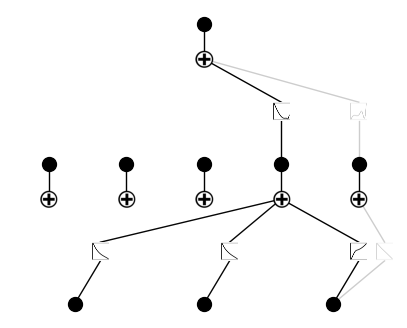

In [124]:
model.plot()

La imagen muestra cómo hay muchas aristas y vértices del grafo que no aportan información. Realizamos la poda de estos elementos.

In [125]:
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


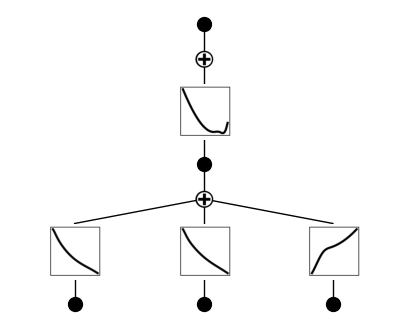

In [126]:
# Mostramos el modelo podado
pruned_model.plot()

Volvemos a entrenar el modelo, una vez realizada la poda.

In [127]:
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.85e-02 | test_loss: 2.02e-02 | reg: 1.04e+01 | : 100%|█| 100/100 [00:20<00:00,  4.94

saving model version 0.3


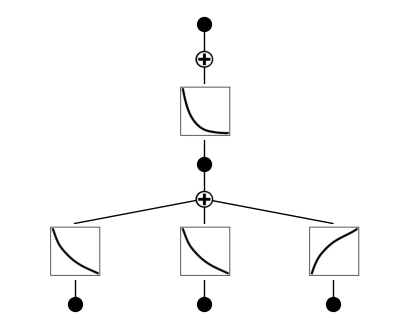

In [128]:
pruned_model.plot()

A continuación, vamos a tratar de fijar funciones simbólicas a cada una de las funciones de activación. Para ello, nos ayudamos de la herramienta que proporciona la librería.

In [129]:
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999652 -11.446185           2                2   -0.689237
1    1/x^0.5    0.999471 -10.858727           2                2   -0.571745
2  1/sqrt(x)    0.999471 -10.858727           2                2   -0.571745
3        1/x    0.999121 -10.134965           2                2   -0.426993
4      1/x^2    0.998608  -9.478782           2                2   -0.295756
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999674 -11.537812           2                2   -0.707562
1    1/x^0.5    0.999602 -11.258160           2                2   -0.651632
2  1/sqrt(x)    0.999602 -11.258160           2                2   -0.651632
3        1/x    0.999329 -10.519491           2                2   -0.503898
4      1/x^2    0.998908  -9.826263           2                2   -0.365253
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Los resultados son los siguientes. En la primera capa hay varias funciones que pueden ajustarse muy bien al resultado (la diferencia de puntuación es mínima). Dado que en la segunda capa la función $\exp$ es claramente la mejor opción, decidimos utilizar en la primera capa la función $\log$ para todas las funciones de activación, ya que la composición de estas dos funciones se comporta bien. Nótese que si fallamos en la elección, siempre podemos repetir este paso. Probamos con esta elección.

In [130]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.9996516108512878
saving model version 0.4
r2 is 0.9996736645698547
saving model version 0.5
r2 is 0.999895453453064
saving model version 0.6
r2 is 0.9997233152389526
saving model version 0.7


Volvemso a entrenar el modelo y vemos el resultado.

In [131]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.19e-06 | test_loss: 1.11e-06 | reg: 0.00e+00 | : 100%|█| 100/100 [00:07<00:00, 12.72

saving model version 0.8


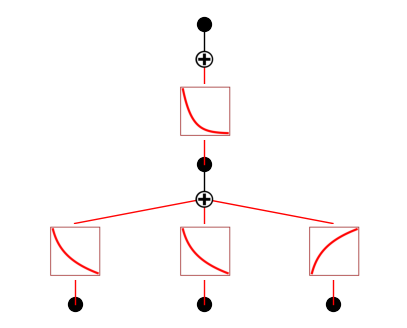

In [132]:
pruned_model.plot()

Como podemos ver la fórmula obtenida se ajusta correctamente a la función que queríamos aprender, recuperando incluso la constante. Nótese que para recuperar la función original bastería con multiplicar por $10^{17}$ la función obtenida.

In [133]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.773*x_1**1.0*x_2**1.0/x_3**2.0